In [1]:
import os
import sys
sys.path.append('../Automatic-Circuit-Discovery/')
sys.path.append('../tracr/')
sys.path.append('..')
import re

import acdc
from acdc.TLACDCExperiment import TLACDCExperiment
from acdc.acdc_utils import TorchIndex, EdgeType
import numpy as np
import torch as t
from torch import Tensor
import einops
import itertools

from transformer_lens import HookedTransformer, ActivationCache

import tqdm.notebook as tqdm
import matplotlib.pyplot as plt
from rich import print as rprint
from rich.table import Table

from jaxtyping import Float, Bool
from typing import Callable, Tuple, Union, Dict, Optional

from utils.prune_utils import get_3_caches, split_layers_and_heads
from ACDCPPExperiment import ACDCPPExperiment

device = t.device('cuda') if t.cuda.is_available() else t.device('cpu')
print(f'Device: {device}')

/Users/canrager/.pyenv/versions/acdc_env/envs/acdcpp_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cpu


# Model Setup

In [2]:
model = HookedTransformer.from_pretrained(
    'gpt2-small',
    center_writing_weights=False,
    center_unembed=False,
    fold_ln=False,
    device=device,
)
model.set_use_hook_mlp_in(True)
model.set_use_split_qkv_input(True)
model.set_use_attn_result(True)

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-small into HookedTransformer


from acdc.ioi.utils import get_ioi_true_edges
ioi_true_edges = get_ioi_true_edges(model)
for (b1, i1, b2, i2), val in ioi_true_edges.items():
    if val:
        print(b1, b2)

# Dataset Setup

In [3]:
from ioi_task.ioi_dataset import IOIDataset, format_prompt, make_table
N = 25
clean_dataset = IOIDataset(
    prompt_type='mixed',
    N=N,
    tokenizer=model.tokenizer,
    prepend_bos=False,
    seed=1,
    device=device
)
corr_dataset = clean_dataset.gen_flipped_prompts('ABC->XYZ, BAB->XYZ')

make_table(
  colnames = ["IOI prompt", "IOI subj", "IOI indirect obj", "ABC prompt"],
  cols = [
    map(format_prompt, clean_dataset.sentences),
    model.to_string(clean_dataset.s_tokenIDs).split(),
    model.to_string(clean_dataset.io_tokenIDs).split(),
    map(format_prompt, clean_dataset.sentences),
  ],
  title = "Sentences from IOI vs ABC distribution",
)

                                      Sentences from IOI vs ABC distribution                                       
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ IOI prompt                              ┃ IOI subj ┃ IOI indirect obj ┃ ABC prompt                              ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ When Victoria and Jane got a snack at   │ Jane     │ Victoria         │ When Victoria and Jane got a snack at   │
│ the store, Jane decided to give it to   │          │                  │ the store, Jane decided to give it to   │
│ Victoria                                │          │                  │ Victoria                                │
│                                         │          │                  │                                         │
│ When Sullivan and Rose got a necklace   │ Sullivan │ Rose             │ When Sullivan and Rose got a necklace   │
│ at the garden, Sullivan decided to give │          │                  │ at the garden, Sullivan decided to give │
│ it to Rose                              │          │                  │ it to Rose                              │
│                                         │          │                  │                                         │
│ When Alan and Alex got a drink at the   │ Alex     │ Alan             │ When Alan and Alex got a drink at the   │
│ store, Alex decided to give it to Alan  │          │                  │ store, Alex decided to give it to Alan  │
│                                         │          │                  │                                         │
│ Then, Jessica and Crystal had a long    │ Jessica  │ Crystal          │ Then, Jessica and Crystal had a long    │
│ argument, and afterwards Jessica said   │          │                  │ argument, and afterwards Jessica said   │
│ to Crystal                              │          │                  │ to Crystal                              │
│                                         │          │                  │                                         │
│ Then, Jonathan and Kevin were working   │ Kevin    │ Jonathan         │ Then, Jonathan and Kevin were working   │
│ at the school. Kevin decided to give a  │          │                  │ at the school. Kevin decided to give a  │
│ necklace to Jonathan                    │          │                  │ necklace to Jonathan                    │
│                                         │          │                  │                                         │
└─────────────────────────────────────────┴──────────┴──────────────────┴─────────────────────────────────────────┘

# Metric Setup

In [4]:
def ave_logit_diff(
    logits: Float[Tensor, 'batch seq d_vocab'],
    ioi_dataset: IOIDataset,
    per_prompt: bool = False
):
    '''
        Return average logit difference between correct and incorrect answers
    '''
    # Get logits for indirect objects
    io_logits = logits[range(logits.size(0)), ioi_dataset.word_idx['end'], ioi_dataset.io_tokenIDs]
    s_logits = logits[range(logits.size(0)), ioi_dataset.word_idx['end'], ioi_dataset.s_tokenIDs]
    # Get logits for subject
    logit_diff = io_logits - s_logits
    return logit_diff if per_prompt else logit_diff.mean()

with t.no_grad():
    clean_logits = model(clean_dataset.toks)
    corrupt_logits = model(corr_dataset.toks)
    clean_logit_diff = ave_logit_diff(clean_logits, clean_dataset).item()
    corrupt_logit_diff = ave_logit_diff(corrupt_logits, corr_dataset).item()

def ioi_metric(
    logits: Float[Tensor, "batch seq_len d_vocab"],
    corrupted_logit_diff: float = corrupt_logit_diff,
    clean_logit_diff: float = clean_logit_diff,
    ioi_dataset: IOIDataset = clean_dataset
 ):
    patched_logit_diff = ave_logit_diff(logits, ioi_dataset)
    return (patched_logit_diff - corrupted_logit_diff) / (clean_logit_diff - corrupted_logit_diff)

def abs_ioi_metric(logits: Float[Tensor, "batch seq_len d_vocab"]):
    return abs(ioi_metric(logits))

def negative_ioi_metric(logits: Float[Tensor, "batch seq_len d_vocab"]):
    return -ioi_metric(logits)

def negative_abs_ioi_metric(logits: Float[Tensor, "batch seq_len d_vocab"]):
    return -abs_ioi_metric(logits)

# Get clean and corrupt logit differences
with t.no_grad():
    clean_metric = ioi_metric(clean_logits, corrupt_logit_diff, clean_logit_diff, clean_dataset)
    corrupt_metric = ioi_metric(corrupt_logits, corrupt_logit_diff, clean_logit_diff, corr_dataset)

print(f'Clean direction: {clean_logit_diff}, Corrupt direction: {corrupt_logit_diff}')
print(f'Clean metric: {clean_metric}, Corrupt metric: {corrupt_metric}')

Clean direction: 2.805161237716675, Corrupt direction: 1.6208322048187256
Clean metric: 1.0, Corrupt metric: 0.0


# Calc attributions

In [13]:
# Calc Node attributions
clean_cache, corrupted_cache, clean_grad_cache = get_3_caches(model, clean_dataset.toks, corr_dataset.toks, negative_abs_ioi_metric, mode="node")
# compute first-order Taylor approximation for each node to get the attribution
clean_head_act = clean_cache.stack_head_results()
corr_head_act = corrupted_cache.stack_head_results()
clean_grad_act = clean_grad_cache.stack_head_results()

# compute attributions of each node
node_attr = (clean_head_act - corr_head_act) * clean_grad_act
# separate layers and heads, sum over d_model (to complete the dot product), batch, and seq
node_attr = split_layers_and_heads(node_attr, model).sum((2, 3, 4)).flatten().abs()

In [6]:
threshold_dummy = 0.1 # Does not make a difference when only running edge based attribution patching, as all attributions are saved in the result dict anyways
RUN_NAME = 'greaterthan_edge_absval'
acdcpp_exp = ACDCPPExperiment(model,
                              clean_dataset.toks,
                              corr_dataset.toks,
                              negative_abs_ioi_metric,
                              negative_abs_ioi_metric,
                              threshold_dummy,
                              run_name=RUN_NAME,
                              verbose=False,
                              attr_absolute_val=True,
                              save_graphs_after=0,
                              pruning_mode="edge",
                              no_pruned_nodes_attr=1
                             )
tlacdc_exp = acdcpp_exp.setup_exp(threshold=threshold_dummy)
attr_results = acdcpp_exp.run_acdcpp(exp=tlacdc_exp, threshold=threshold_dummy)

ln_final.hook_normalized
ln_final.hook_scale
blocks.11.hook_resid_post
blocks.11.hook_mlp_out
blocks.11.mlp.hook_post
blocks.11.mlp.hook_pre
blocks.11.ln2.hook_normalized
blocks.11.ln2.hook_scale
blocks.11.hook_mlp_in
blocks.11.hook_resid_mid
blocks.11.hook_attn_out
blocks.11.attn.hook_result
blocks.11.attn.hook_z
blocks.11.attn.hook_pattern
blocks.11.attn.hook_attn_scores
blocks.11.attn.hook_v
blocks.11.attn.hook_k
blocks.11.attn.hook_q
blocks.11.ln1.hook_normalized
blocks.11.ln1.hook_scale
blocks.11.hook_v_input
blocks.11.hook_k_input
blocks.11.hook_q_input
blocks.11.hook_resid_pre
blocks.10.hook_resid_post
blocks.10.hook_mlp_out
blocks.10.mlp.hook_post
blocks.10.mlp.hook_pre
blocks.10.ln2.hook_normalized
blocks.10.ln2.hook_scale
blocks.10.hook_mlp_in
blocks.10.hook_resid_mid
blocks.10.hook_attn_out
blocks.10.attn.hook_result
blocks.10.attn.hook_z
blocks.10.attn.hook_pattern
blocks.10.attn.hook_attn_scores
blocks.10.attn.hook_v
blocks.10.attn.hook_k
blocks.10.attn.hook_q
blocks.10.ln

100%|██████████| 69420/69420 [00:12<00:00, 5350.47it/s] 


Text(0.5, 1.0, 'Number of remaining edges/nodes after ACDC++ only \n(IOI task, ADCD threshold: 0.0575)')

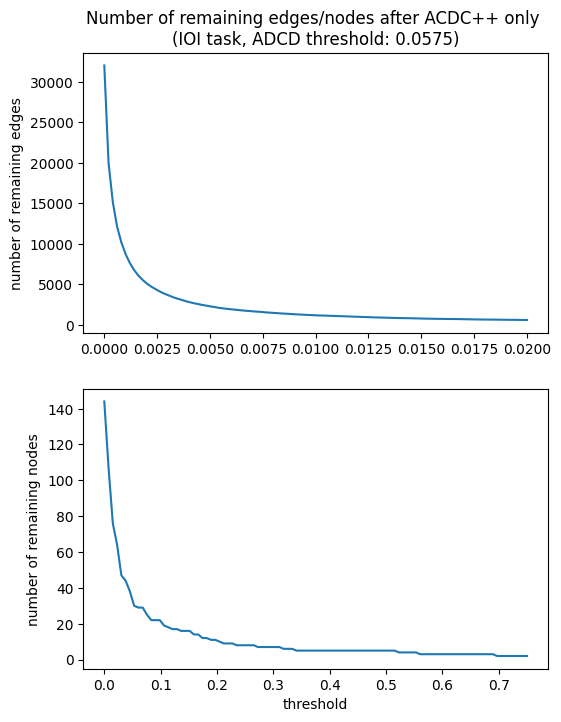

In [24]:
attr_vals = np.array(list(attr_results[1].values()))
thresholds_edge = np.linspace(min(attr_vals), 0.02, 100)
thresholds_node = np.linspace(min(attr_vals), 0.75, 100)
num_edges_above_thresh = np.array(
    [sum(attr_vals > t) for t in thresholds_edge]
)
num_nodes_above_thresh = np.array(
    [sum(node_attr > t) for t in thresholds_node]
)

fig, ax = plt.subplots(2,1, figsize=(6,8))

ax[0].plot(thresholds_edge, num_edges_above_thresh)
ax[1].plot(thresholds_node, num_nodes_above_thresh)
ax[1].set_xlabel("threshold")
ax[0].set_ylabel("number of remaining edges")
ax[1].set_ylabel("number of remaining nodes")
ax[0].set_title("Number of remaining edges/nodes after ACDC++ only \n(IOI task, ADCD threshold: 0.0575)")